In [357]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import accumulate
from icecream import ic

In [358]:
INSTANCES = [
    {"UNIVERSE_SIZE": 100, "NUM_SETS": 10, "DENSITY": 0.2},
    {"UNIVERSE_SIZE": 1000, "NUM_SETS": 100, "DENSITY": 0.2},
    {"UNIVERSE_SIZE": 10_000, "NUM_SETS": 1_000, "DENSITY": 0.2},
    {"UNIVERSE_SIZE": 100_000, "NUM_SETS": 10_000, "DENSITY": 0.1},
    {"UNIVERSE_SIZE": 100_000, "NUM_SETS": 10_000, "DENSITY": 0.2},
    {"UNIVERSE_SIZE": 100_000, "NUM_SETS": 10_000, "DENSITY": 0.3}
]

In [359]:
def generate_instance(universe_size, num_sets, density):
    sets = np.random.random((num_sets, universe_size)) < density
    for s in range(universe_size):
        if not np.any(sets[:, s]):
            sets[np.random.randint(num_sets), s] = True
    costs = np.power(sets.sum(axis=1), 1.1)
    return sets, costs

In [360]:
def valid(solution, sets):
    phenotype = np.logical_or.reduce(sets[solution])
    return np.all(phenotype)

def cost(solution, costs):
    return costs[solution].sum()

In [361]:
def fitness(solution, sets, costs):
    return (valid(solution, sets), -cost(solution, costs))

In [362]:
def tweak(solution, num_sets, rng):
    new_solution = solution.copy()
    i = rng.integers(0, num_sets)
    new_solution[i] = not new_solution[i]
    return new_solution

def multiple_mutation(solution, num_sets, rng):
    mask = rng.random(num_sets) < 0.01
    new_solution = np.logical_xor(solution, mask)
    return new_solution

## Steepest Step and Restart


In [363]:
def solve_instance(instance, max_iterations=10_000):
    sets, costs = generate_instance(instance["UNIVERSE_SIZE"], instance["NUM_SETS"], instance["DENSITY"])
    rng = np.random.Generator(np.random.PCG64([instance["UNIVERSE_SIZE"], instance["NUM_SETS"], int(10_000 *instance["DENSITY"])]))
    
    solution = rng.random(instance["NUM_SETS"]) < 1
    solution_fitness = fitness(solution, sets, costs)
    
    best_solution = solution.copy()
    best_fitness = solution_fitness
    history = [solution_fitness[1]]
    
    iterations_without_improvement = 0
    max_iterations_without_improvement = 1000
    
    for _ in range(max_iterations):
        if iterations_without_improvement < max_iterations_without_improvement:
            new_solution = tweak(solution, instance["NUM_SETS"], rng)
        else:
            new_solution = multiple_mutation(solution, instance["NUM_SETS"], rng)
        
        new_fitness = fitness(new_solution, sets, costs)
        history.append(new_fitness[1])
        
        if new_fitness > solution_fitness:
            solution = new_solution
            solution_fitness = new_fitness 
            iterations_without_improvement = 0
            
            if solution_fitness > best_fitness:
                best_solution = solution.copy()
                best_fitness = solution_fitness
        else:
            iterations_without_improvement += 1
    
    return best_solution, best_fitness, history

Instance 1 - Best fitness: (np.True_, np.float64(-249.16813885577193))
Instance 2 - Best fitness: (np.True_, np.float64(-6169.280804802059))
Instance 3 - Best fitness: (np.True_, np.float64(-128590.34739982823))
Instance 4 - Best fitness: (np.True_, np.float64(-91344076.17349751))
Instance 5 - Best fitness: (np.True_, np.float64(-197351868.52663457))
Instance 6 - Best fitness: (np.True_, np.float64(-309613232.6563313))


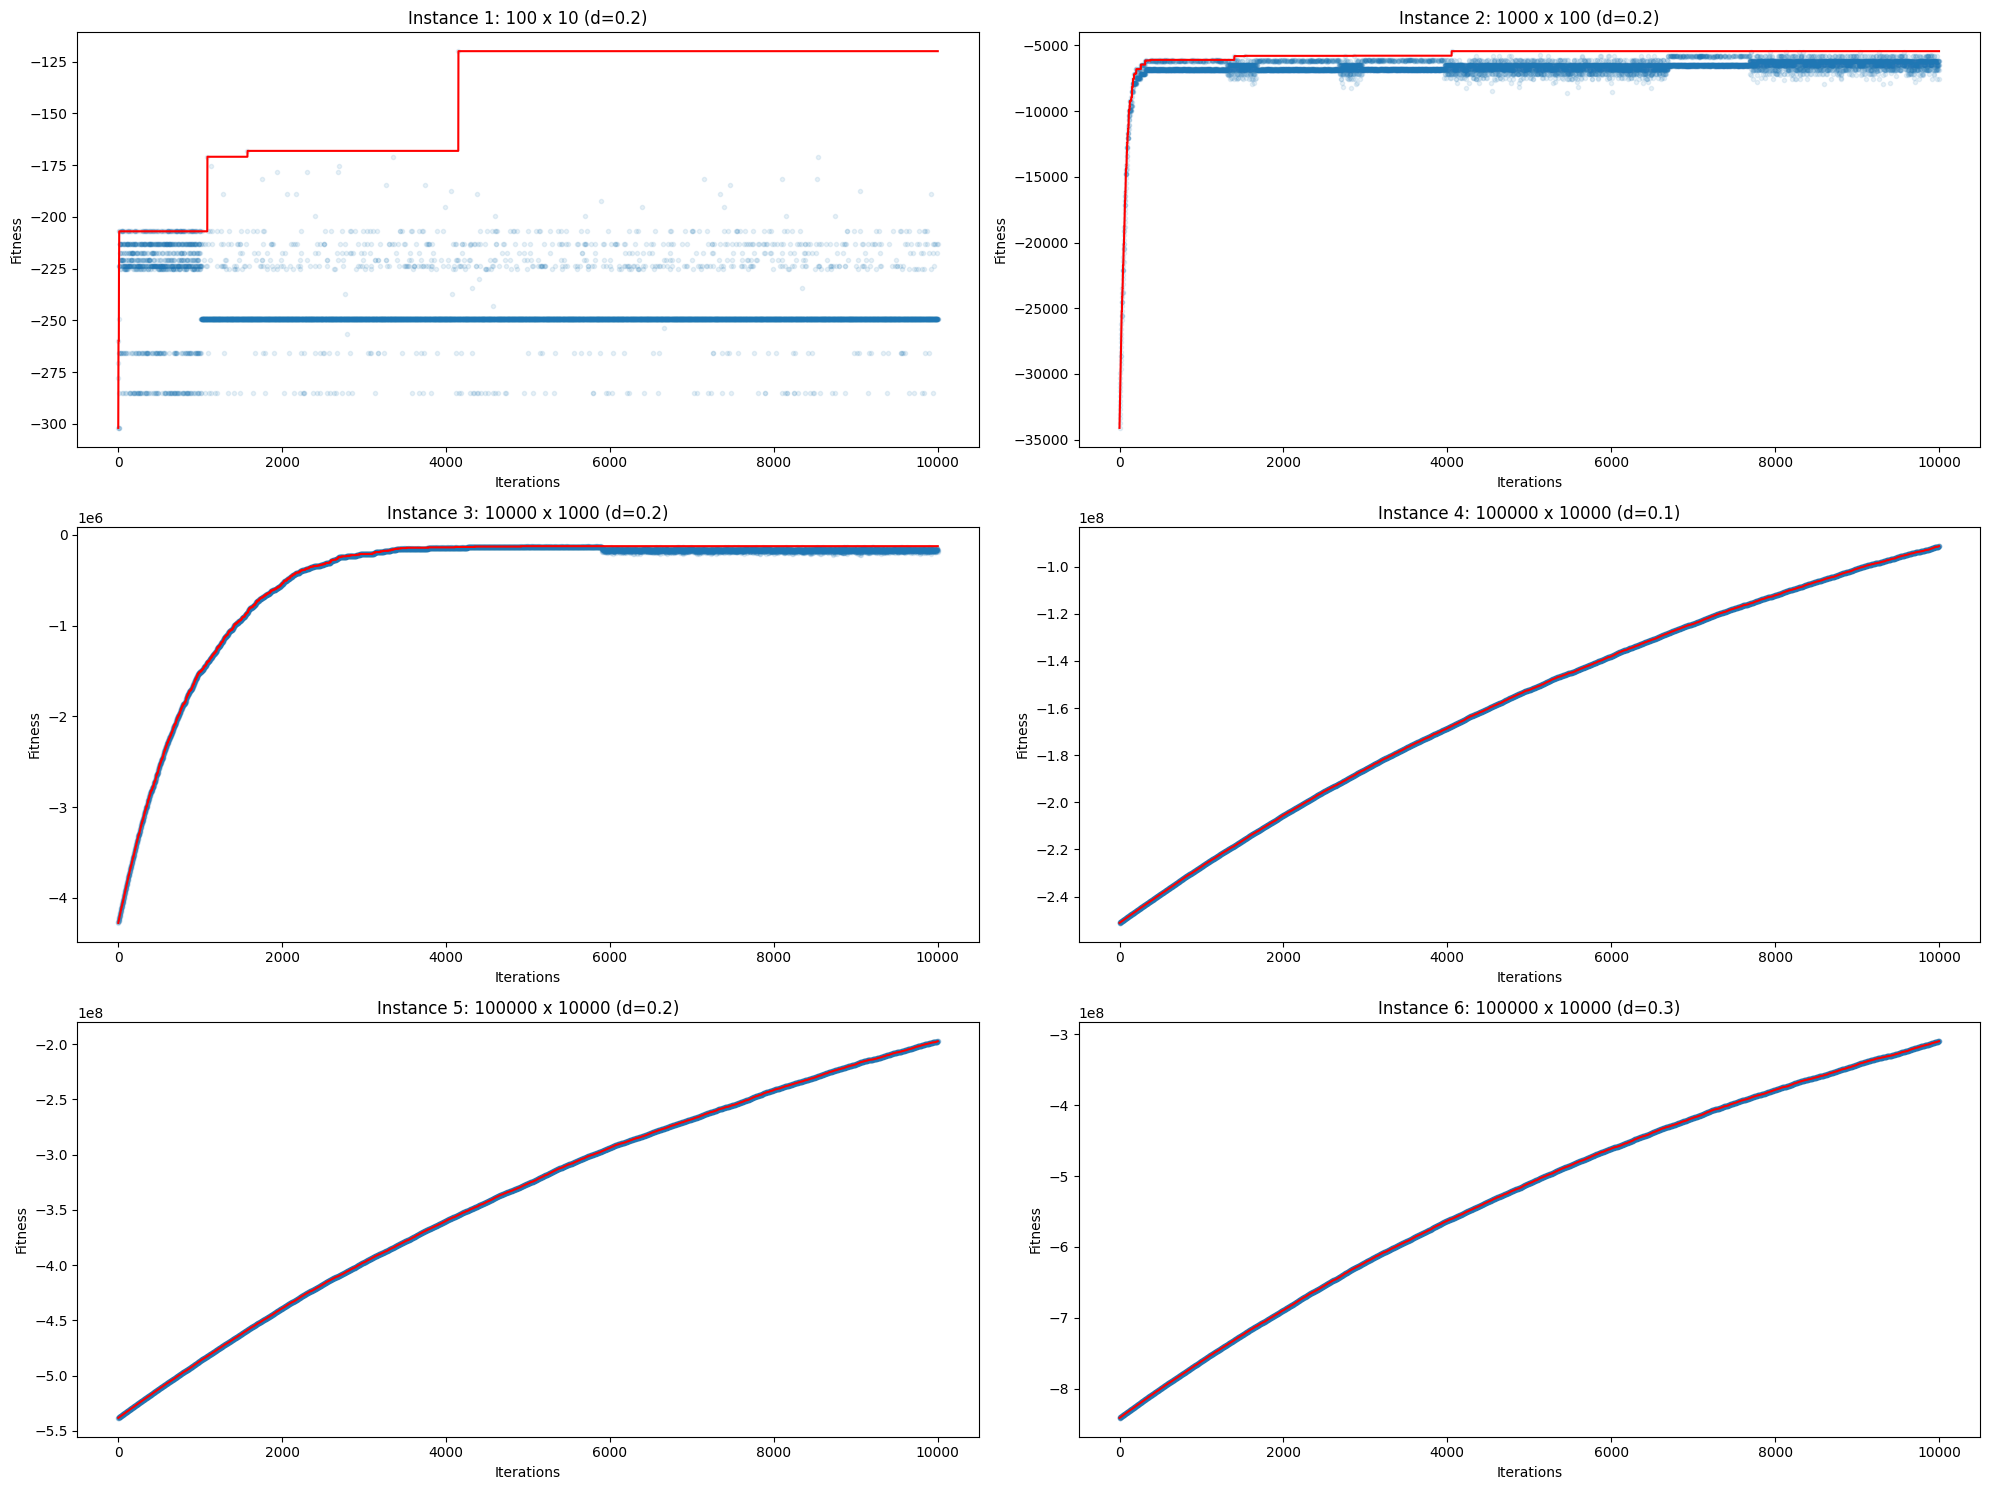

In [364]:
plt.figure(figsize=(20, 15))

for idx, instance in enumerate(INSTANCES, 1):
    solution, fitness_value, history = solve_instance(instance)
    
    plt.subplot(3, 2, idx)
    plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
    plt.scatter(range(len(history)), history, marker=".", alpha=0.1)
    plt.title(f"Instance {idx}: {instance['UNIVERSE_SIZE']} x {instance['NUM_SETS']} (d={instance['DENSITY']})")
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    
    print(f"Instance {idx} - Best fitness: {fitness_value}")

plt.tight_layout()
plt.show()


## Hill climber

In [365]:
def solve_instance_hc(instance, max_iterations=10_000):
    sets, costs = generate_instance(instance["UNIVERSE_SIZE"], instance["NUM_SETS"], instance["DENSITY"])
    rng = np.random.Generator(np.random.PCG64([instance["UNIVERSE_SIZE"], instance["NUM_SETS"], int(10_000 *instance["DENSITY"])]))

    
    solution = rng.random(instance["NUM_SETS"]) < 1
    solution_fitness = fitness(solution, sets, costs)
    history = [solution_fitness[1]]
    
    for _ in range(max_iterations):
        new_solution = tweak(solution, instance["NUM_SETS"], rng)
        f=fitness(new_solution, sets, costs)
        history.append(f[1])
        if f > solution_fitness:
            solution=new_solution
            solution_fitness=fitness(solution,sets, costs)
    
    return solution, solution_fitness, history

Instance 1 - Best fitness: (np.True_, np.float64(-264.28492999419615))
Instance 2 - Best fitness: (np.True_, np.float64(-7114.9738397370265))
Instance 3 - Best fitness: (np.True_, np.float64(-133086.79954348))
Instance 4 - Best fitness: (np.True_, np.float64(-91384194.01992775))
Instance 5 - Best fitness: (np.True_, np.float64(-197374981.26421154))
Instance 6 - Best fitness: (np.True_, np.float64(-309563067.8671589))


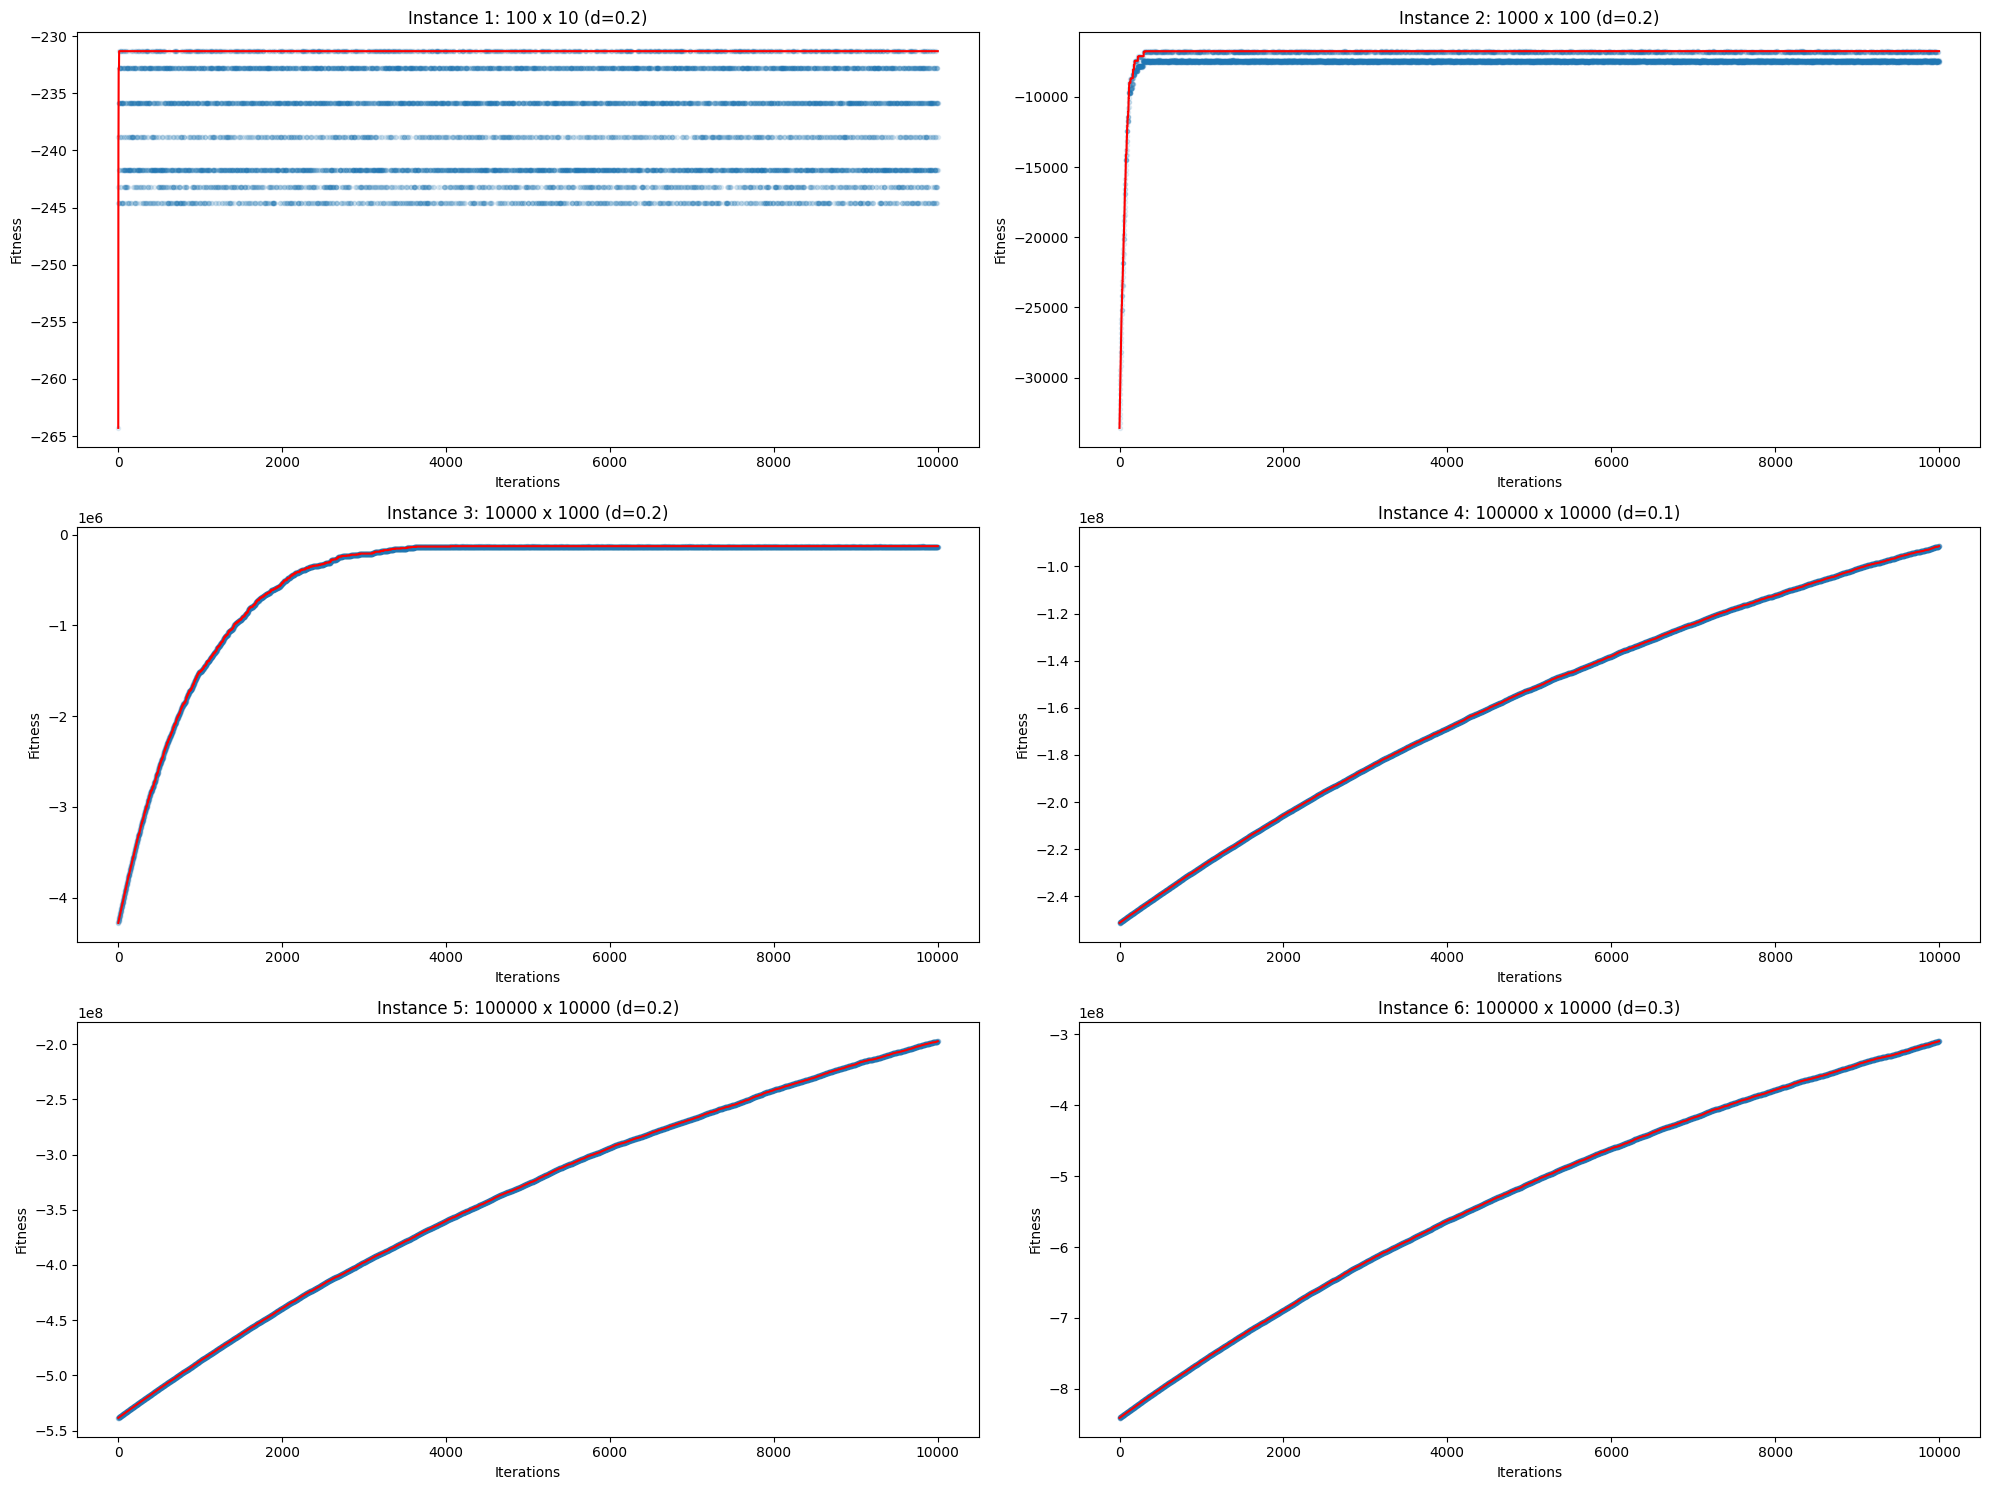

In [366]:
plt.figure(figsize=(20, 15))

for idx, instance in enumerate(INSTANCES, 1):
    solution, fitness_value, history = solve_instance_hc(instance)
    
    plt.subplot(3, 2, idx)
    plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
    plt.scatter(range(len(history)), history, marker=".", alpha=0.1)
    plt.title(f"Instance {idx}: {instance['UNIVERSE_SIZE']} x {instance['NUM_SETS']} (d={instance['DENSITY']})")
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    
    print(f"Instance {idx} - Best fitness: {fitness_value}")

plt.tight_layout()
plt.show()


# Simple RHCM

In [367]:
def solve_instance_rhcm(instance, max_iterations=10_000):
    sets, costs = generate_instance(instance["UNIVERSE_SIZE"], instance["NUM_SETS"], instance["DENSITY"])
    rng = np.random.Generator(np.random.PCG64([instance["UNIVERSE_SIZE"], instance["NUM_SETS"], int(10_000 *instance["DENSITY"])]))

    
    solution = rng.random(instance["NUM_SETS"]) < 1
    solution_fitness = fitness(solution, sets, costs)
    history = [solution_fitness[1]]
    
    for _ in range(max_iterations):
        new_solution = multiple_mutation(solution, instance["NUM_SETS"], rng)
        f=fitness(new_solution, sets, costs)
        history.append(f[1])
        if f > solution_fitness:
            solution=new_solution
            solution_fitness=fitness(solution,sets, costs)
    
    return solution, solution_fitness, history

Instance 1 - Best fitness: (np.True_, np.float64(-298.96678430020825))
Instance 2 - Best fitness: (np.True_, np.float64(-6501.636301844317))
Instance 3 - Best fitness: (np.True_, np.float64(-610570.2385824064))
Instance 4 - Best fitness: (np.True_, np.float64(-93741359.77852917))
Instance 5 - Best fitness: (np.True_, np.float64(-200822820.81165922))
Instance 6 - Best fitness: (np.True_, np.float64(-311858468.4641721))


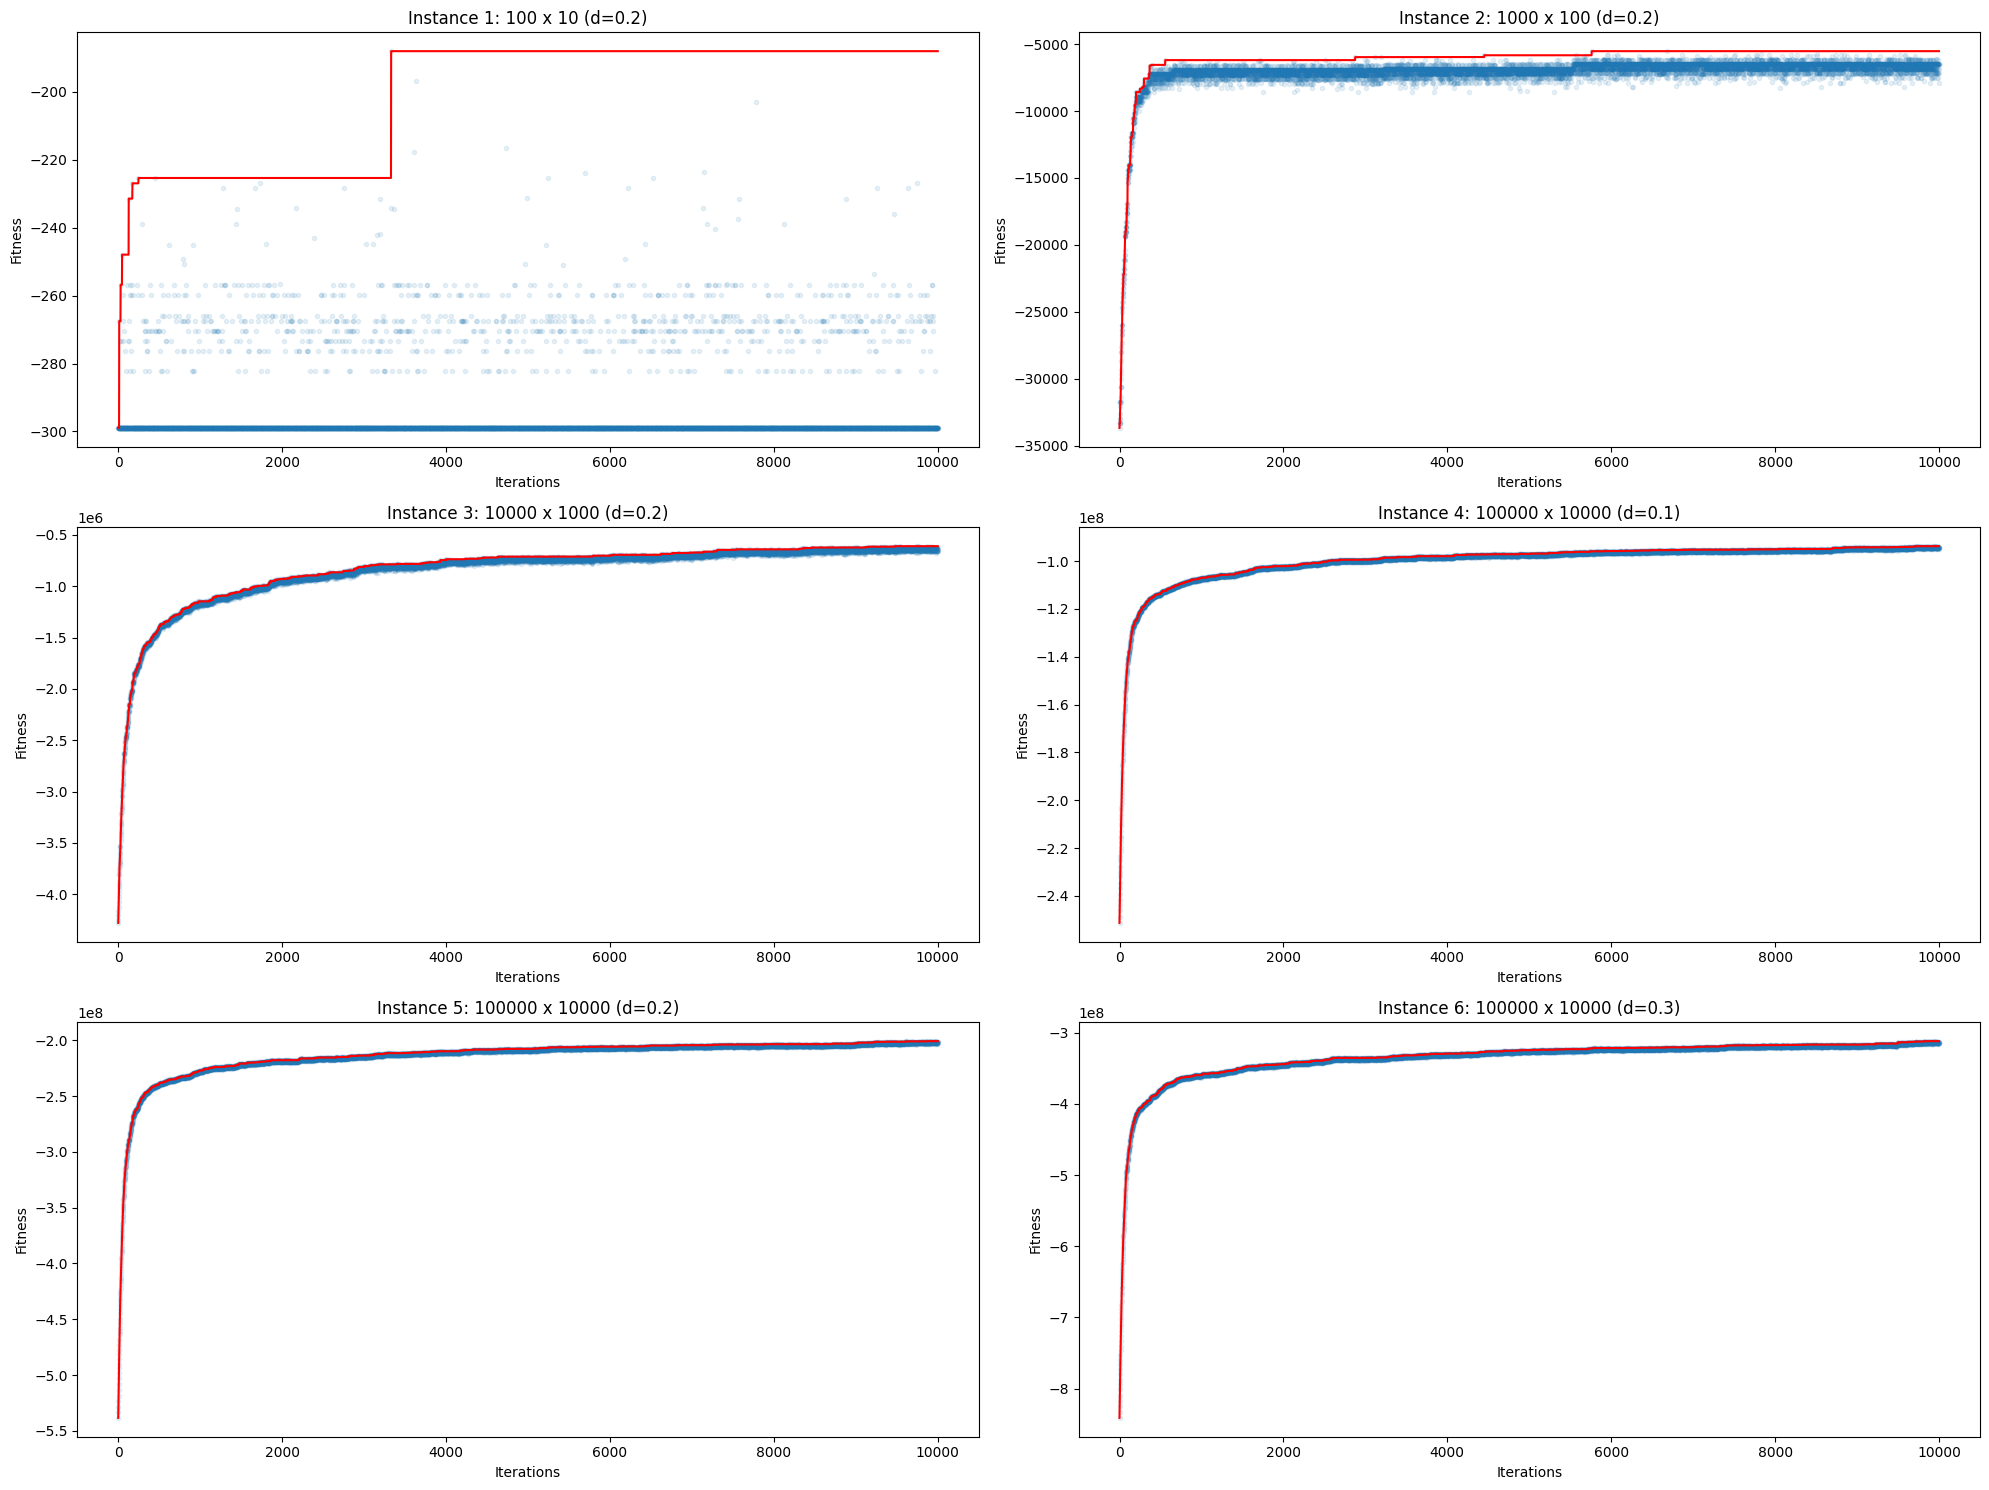

In [368]:
plt.figure(figsize=(20, 15))

for idx, instance in enumerate(INSTANCES, 1):
    solution, fitness_value, history = solve_instance_rhcm(instance)
    
    plt.subplot(3, 2, idx)
    plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
    plt.scatter(range(len(history)), history, marker=".", alpha=0.1)
    plt.title(f"Instance {idx}: {instance['UNIVERSE_SIZE']} x {instance['NUM_SETS']} (d={instance['DENSITY']})")
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    
    print(f"Instance {idx} - Best fitness: {fitness_value}")

plt.tight_layout()
plt.show()


# Improved RHCM


In [369]:
def multiple_mutation_improve(solution, strength,rng,num_sets):
    mask = rng.random(num_sets) < strength
    if not np.any(mask):
        mask[np.random.randint(num_sets)]=True
    
    new_solution=np.logical_xor(solution,mask)

    return new_solution


In [370]:
def solve_instance_with_adaptive_strength(instance, max_iterations=10_000, buffer_size=500):
    sets, costs = generate_instance(instance["UNIVERSE_SIZE"], instance["NUM_SETS"], instance["DENSITY"])
    rng = np.random.Generator(np.random.PCG64([instance["UNIVERSE_SIZE"], instance["NUM_SETS"], int(10_000 *instance["DENSITY"])]))
    
    if instance["UNIVERSE_SIZE"]<=1000:
        solution = rng.random(instance["NUM_SETS"]) < 1
    else:
        solution = rng.random(instance["NUM_SETS"]) < 0.5
    solution_fitness = fitness(solution, sets, costs)
    history = [solution_fitness[1]]
    
    
    strength = 0.5  
    buffer = []  
    
    for _ in range(max_iterations):

        new_solution = multiple_mutation_improve(solution, strength,rng,instance["NUM_SETS"])
        f = fitness(new_solution, sets, costs)
        history.append(f[1])
        
        
        buffer.append(f > solution_fitness)
        buffer = buffer[-buffer_size:]  
        
        if sum(buffer) > buffer_size/2:
            strength *= 1.3  
        elif sum(buffer) < buffer_size/2:
            strength /= 1.3  
        
        if f > solution_fitness:
            solution = new_solution
            solution_fitness = f
    
    return solution, solution_fitness, history

Instance 1 - Best fitness: (np.True_, np.float64(-279.27185937563496))
Instance 2 - Best fitness: (np.True_, np.float64(-6960.54094423811))
Instance 3 - Best fitness: (np.True_, np.float64(-124682.61385680205))
Instance 4 - Best fitness: (np.True_, np.float64(-45224974.68396935))
Instance 5 - Best fitness: (np.True_, np.float64(-94720184.02507345))
Instance 6 - Best fitness: (np.True_, np.float64(-156359019.70110178))


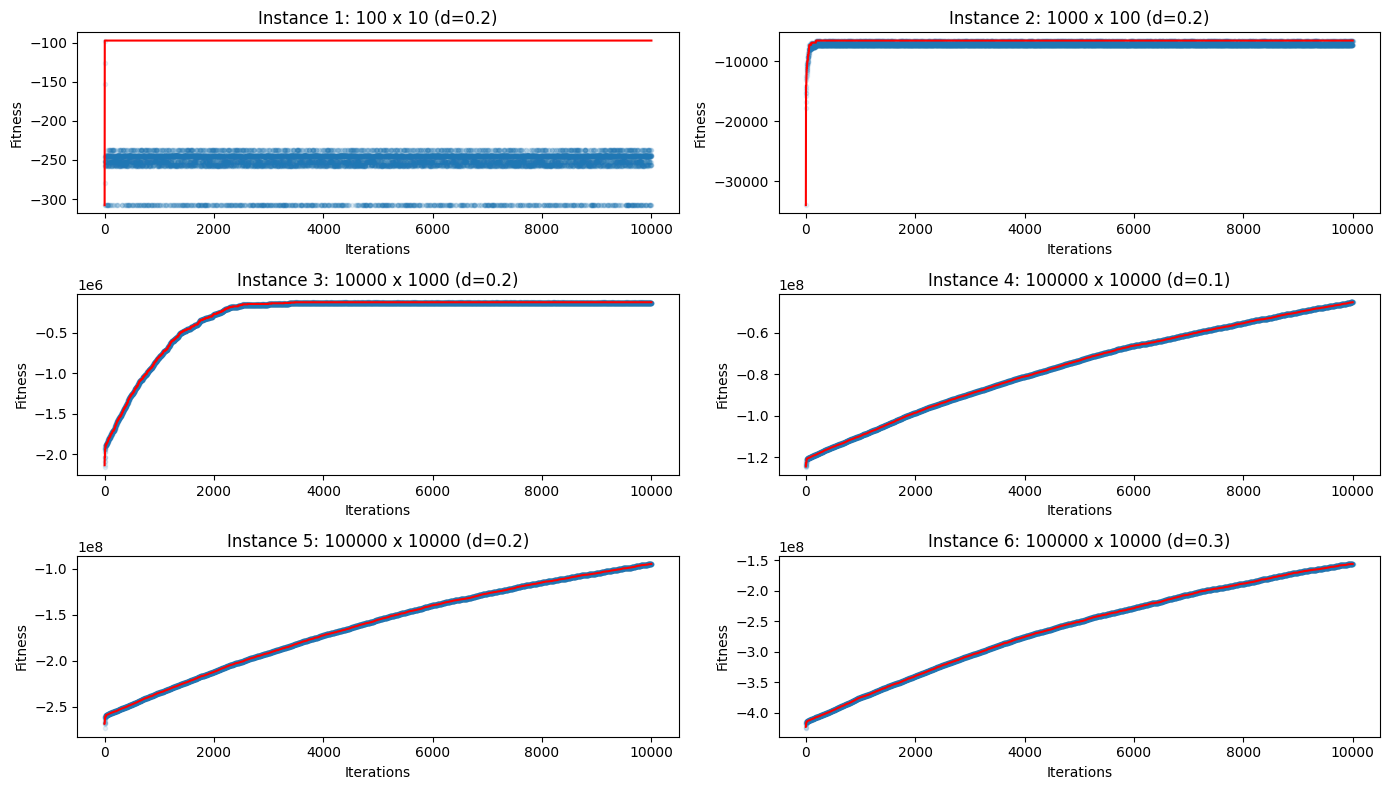

In [371]:
plt.figure(figsize=(14, 8))

for idx, instance in enumerate(INSTANCES, 1):
    solution, fitness_value, history = solve_instance_with_adaptive_strength(instance)
    
    plt.subplot(3, 2, idx)
    plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
    plt.scatter(range(len(history)), history, marker=".", alpha=0.1)
    plt.title(f"Instance {idx}: {instance['UNIVERSE_SIZE']} x {instance['NUM_SETS']} (d={instance['DENSITY']})")
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    
    print(f"Instance {idx} - Best fitness: {fitness_value}")

plt.tight_layout()
plt.show()

From the results obtained, after different try it seems that the Improved RHCM strategy produced the best results,especially for large instances.